In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
import seaborn as sns
from scipy import stats
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

Functions from the notebook ""

In [4]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

## Overview of analysis
So we want to take a look at what the high prior knowledge are doing. Remember that we have 22 such students, 19 HH and 3 HL. Let's keep the HL and call HH+HL = HH

In [5]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [6]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 19
high low 3
low high 38
low low 36


We want to compare the three groups to each other. We would like to know if:
- HH look like LL in which case LL use experts strategies that are productive with certain level of prior knowledge
- HH look like LH in which case they used productive strategies

We need to make a new funciton to run the sequence mining with 3 groups.

### Let's make those three groups

In [7]:
def label_3_groups (row):
    if row['split pre']  == 'high' and row['split post t2'] == 'high':
        return 'HH'
    if row['split pre']  == 'high' and row['split post t2'] == 'low':
        return 'HL'
    if row['split pre']  == 'low' and row['split post t2'] == 'high':
        return 'LH'
    if row['split pre']  == 'low' and row['split post t2'] == 'low':
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

### Let's run the sequence mining like we usually do on all 3 groups

In [75]:
students = list(set(get_students()) - set(df_scores[df_scores['three groups']=='HL']['student']))
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 1
longest_seq_length = 10

### PARAMETERS
attribute = 'three groups'
level1 = 'LH'
level2 = 'LL'
level3 = 'HH'
family_category = "Family"
group_sizes = np.array([len(set(df_scores[df_scores['three groups']==level1]['student'])),len(set(df_scores[df_scores['three groups']==level2]['student'])),len(set(df_scores[df_scores['three groups']==level3]['student']))])


BINS = 1
axis = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          BINS,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_group = {s:(counts.T/group_sizes).T for s,counts in sequence_counts_group.iteritems()}
tops_group = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
axis = None
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_both = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_both.iteritems()}
tops_both = get_top_seqs(rank_sequences(sequence_counts_both,BINS,axis),15)

axis = 0
tops_time = get_top_seqs(rank_sequences(sequence_counts_both,BINS,axis),15)

Getting sequence use over 1 time bins for 93 students split by three groups. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 93 students split by three groups. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


In [76]:
table = [['SEQ','IG','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
tops_group.sort(key=lambda x: -x[1])
for seq,ig in tops_group:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    lh,ll,hh = (sequence_counts_group[seq].T*group_sizes)[0]
    tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
    chi2, p, dof, ex = stats.chi2_contingency(tb, correction=False)
    res = (tb - ex)/np.sqrt(ex)
    cmarg = np.array(tb).sum(axis=0)
    rmarg = np.array(tb).sum(axis=1)
    res_adj = res
    res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
    n = np.array(tb).sum()
    row = [seq, str(round(ig,2))] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
    table.append(row)
print tabulate(table)

--------  ----  --  --  --  ------  -----  ------  ------  ------
SEQ       IG    LH  LL  HH  chi^2   p-val  LH-res  LL-res  HH-res
CPCTsC    0.22  13  36  10  7.475   0.024  -1.63   2.72    -1.31
PTcCTc    0.2   47  33  10  7.648   0.022  2.19    -0.17   -2.46
TsCTsC    0.19  15  36  10  6.352   0.042  -1.3    2.48    -1.41
PCTcCP    0.16  21  36  10  4.84    0.089  -0.68   2.02    -1.61
PCPTs     0.14  26  11  36  5.223   0.073  0.72    -2.1    1.67
CTsCTs    0.12  26  44  15  5.468   0.065  -0.84   2.19    -1.62
PCTcCTcC  0.12  13  36  36  6.16    0.046  -2.48   1.6     1.1
PTsPC     0.12  52  19  52  10.144  0.006  2.1     -3.18   1.28
TbPCP     0.11  23  16  42  4.361   0.113  -0.19   -1.43   1.97
CPTs      0.1   39  19  52  6.799   0.033  0.85    -2.41   1.87
PTsP      0.09  60  25  57  10.692  0.005  2.3     -3.26   1.14
TcCPC     0.09  21  50  31  6.948   0.031  -2.25   2.52    -0.29
PCTbP     0.08  21  16  36  2.982   0.225  -0.29   -1.08   1.67
PTcPCP    0.08  36  16  21  4.2

In [49]:
table = [['SEQ','IG','t1','t2','t3', 't4']]
tops_time.sort(key=lambda x: -x[1])
for seq,ig in tops_time:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_time[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))] + [int(x*100) for x in np.sum((sequence_counts_time[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

------  ----  --  --  --  --
SEQ     IG    t1  t2  t3  t4
CPTb    1.41  30  1   0   2
TbCPC   1.19  27  3   0   3
PTbC    1.08  29  3   2   1
TbCP    1.02  32  4   1   3
PTb     0.97  39  5   3   2
CTbPC   0.75  31  2   10  3
TbCTb   0.74  34  3   6   3
CTbP    0.68  41  5   10  4
TbPCP   0.64  19  2   5   2
TbPC    0.58  40  6   11  5
PCTbP   0.54  13  3   2   4
PCTsP   0.46  21  18  11  0
TbP     0.46  47  10  12  7
PCPTs   0.43  15  6   1   3
CTsPTs  0.42  25  18  9   1
------  ----  --  --  --  --


In [50]:
table = [['SEQ','IG','LH','LL','HH','t1','t2','t3','t4']]
tops_both.sort(key=lambda x: -x[1])
for seq,ig in tops_both:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_both[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))] + [int(x*100) for x in np.sum(sequence_counts_time[seq], axis=1)] + [int(x*100) for x in np.sum((sequence_counts_time[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

-------  ----  --  --  --  --  --  --  --
SEQ      IG    LH  LL  HH  t1  t2  t3  t4
CPTb     1.53  36  27  36  30  1   0   2
TbCPC    1.32  42  30  26  27  3   0   3
PTbC     1.24  31  36  42  29  3   2   1
TbCP     1.12  47  33  42  32  4   1   3
PTb      1.05  52  41  63  39  5   3   2
PCTbP    0.94  21  19  36  13  3   2   4
TbPCP    0.87  28  22  42  19  2   5   2
CTbPC    0.85  42  47  57  31  2   10  3
TbCTb    0.8   44  47  52  34  3   6   3
CTbP     0.78  52  63  78  41  5   10  4
TbPC     0.67  65  58  73  40  6   11  5
PCPTs    0.66  26  13  47  15  6   1   3
TsCTsC   0.64  15  44  10  8   7   6   3
PTcPCTc  0.6   26  44  15  3   11  12  3
CPTsP    0.59  31  16  42  12  9   2   3
-------  ----  --  --  --  --  --  --  --


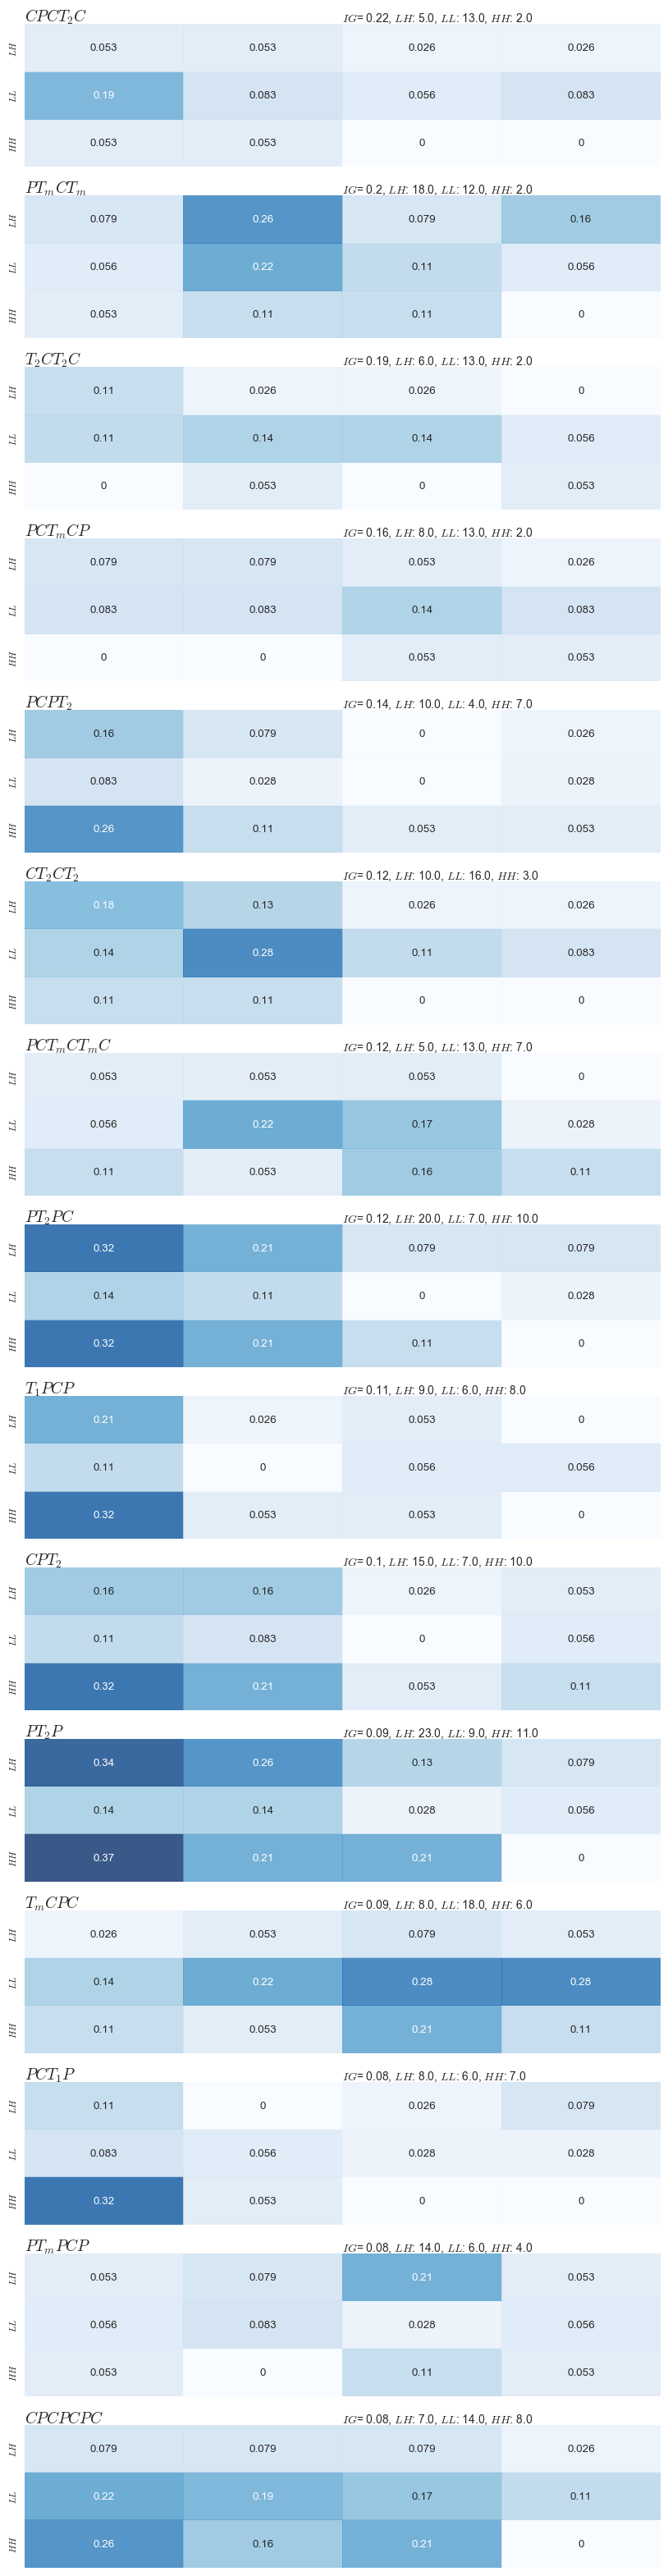

In [51]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops_group)[0]
fig, axes = plt.subplots(len(tops_group),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops_group):
    ax = axes[i]
    data = sequence_counts_both[seq]
    hl,ll,hh = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $HH$: {3}".format(str(round(ig,2)),hl,ll,hh), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,40)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

In [88]:
all_actions = [('Tb',0),('Ts',0),('Tc',0),('P',0),('C',0)]
table = [['SEQ','IG','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]

seq = 'PTb'
lh,ll,hh = (sequence_counts_group[seq].T*group_sizes)[0]
tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
chi2, p, dof, ex = stats.chi2_contingency(tb, correction=False)
res = (tb - ex)/np.sqrt(ex)
cmarg = np.array(tb).sum(axis=0)
rmarg = np.array(tb).sum(axis=1)
res_adj = res
res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
n = np.array(tb).sum()
row = [seq, str(round(ig,2))] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
table.append(row)
print tabulate(table)

---  ---  --  --  --  -----  -----  ------  ------  ------
SEQ  IG   LH  LL  HH  chi^2  p-val  LH-res  LL-res  HH-res
PTb  0.0  47  36  52  1.658  0.437  0.53    -1.23   0.84
---  ---  --  --  --  -----  -----  ------  ------  ------


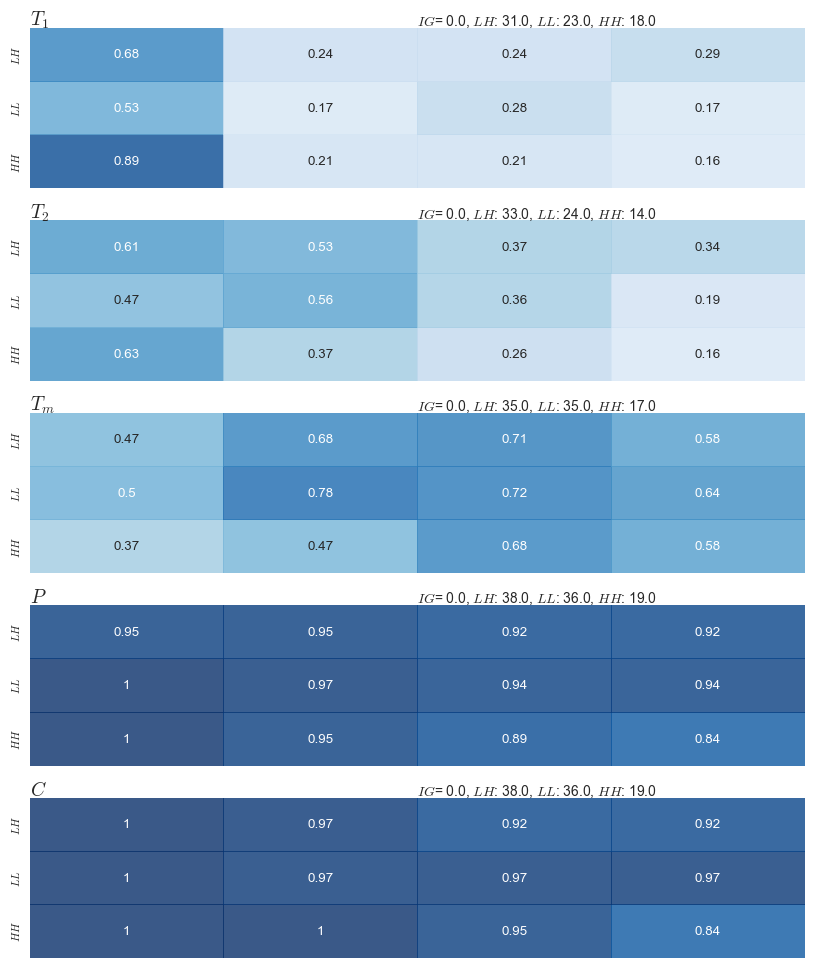

In [56]:
all_actions = [('Tb',0),('Ts',0),('Tc',0),('P',0),('C',0),]
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*all_actions)[0]
fig, axes = plt.subplots(len(all_actions),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])

for i,(seq,ig) in enumerate(all_actions):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll,h_ = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $HH$: {3}".format(str(round(ig,2)),hl,ll,h_), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,12)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

### Let's analyze the building block $T_1P$

In [26]:
print sequence_counts_both['TbP']*group_sizes[:,None]

[[ 15.   4.   5.   4.]
 [ 15.   3.   5.   2.]
 [ 14.   3.   2.   1.]]


In [74]:
seq = 'PCPTs'
arr = sequence_counts_group[seq]*group_sizes[:,None]
print arr
print sequence_counts_group[seq]
# print group_sizes
# print sequence_counts_both[seq]*group_sizes[:,None]

lh = arr[0]
ll = arr[1]
hh = arr[2]

table = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
print table
chi2, p, dof, ex = stats.chi2_contingency(table, correction=False)
print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

[[ 10.]
 [  4.]
 [  7.]]
[[ 0.26]
 [ 0.11]
 [ 0.37]]
[[array([ 10.]), array([ 28.])], [array([ 4.]), array([ 32.])], [array([ 7.]), array([ 12.])]]
Chi^2 = 5.22277917015, p = 0.0734324322214, dof = 2


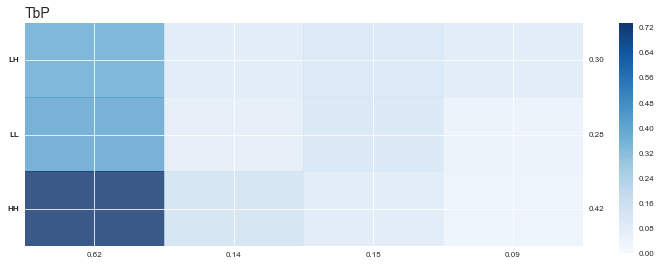

In [15]:
plot = plot_heat_map(sequence_counts_both['TbP'],'TbP',('LH','LL','HH'))

In [16]:
blocks_LH, time_coords_LH =  get_blocks_withTime_new(df,get_students('three groups','LH'),"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,get_students('three groups','LL'),"Family",start=False,ignore=['I'], as_list=True)
blocks_HH, time_coords_HH =  get_blocks_withTime_new(df,get_students('three groups','HH'),"Family",start=False,ignore=['I'], as_list=True)

In [17]:
def get_frequencies(seq_of_interest,blocks1,blocks2,blocks3,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(occurrences(''.join(seq),seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks3.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks3.iteritems()}
    return freq1.values(),freq2.values(),freq3.values()

def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def make_hist_continuous(seq_of_interest,freq_HL,freq_LL,freq_HH):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    bins = np.arange(0,1.05,0.05)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.hist(freq_HH,color = 'g',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue) and HH (green)".format(seq_of_interest))
    return plt

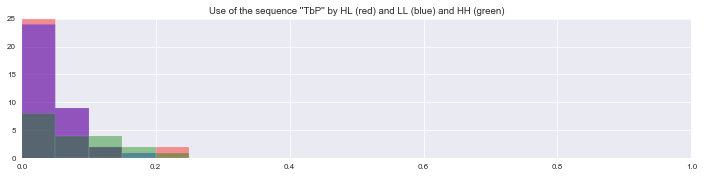

In [18]:
seq = 'TbP'
freq_LH,freq_LL,freq_HH = get_frequencies(seq,blocks_LH,blocks_LL,blocks_HH,normalize_by='length')
plot = make_hist_continuous(seq,freq_LH,freq_LL,freq_HH)
# plot.show()
# perform_comparative_stats(seq,freq_HL,freq_LL)
# freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
# plot = make_hist_continuous(seq,freq_HL,freq_LL)
# plot.show()
# perform_comparative_stats(seq,freq_HL,freq_LL)

In [19]:
chi2, p, dof, ex = stats.chi2_contingency(sequence_counts_both['TbP']*group_sizes[:,None], correction=False)
print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

Chi^2 = 2.48804947434, p = 0.869802714937, dof = 6
